In [1]:
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
scaler = MinMaxScaler()

edf = pd.read_csv('expenses dataset.csv')
sdf = pd.read_csv('sales dataset.csv')
edf['expenseDate'] = pd.to_datetime(edf['expenseDate'], infer_datetime_format=True)
sdf['salesDate'] = pd.to_datetime(sdf['salesDate'], infer_datetime_format=True)

In [2]:
selected_columns =['expenseAmount', 'expenseDate']
edf = edf[selected_columns]
selected_columns1 =['salesAmount', 'salesDate']
sdf = sdf[selected_columns1]

In [3]:
edf['eYear'] = edf['expenseDate'].dt.year
edf['eMonth'] = edf['expenseDate'].dt.month
sdf['sYear'] = sdf['salesDate'].dt.year
sdf['sMonth'] = sdf['salesDate'].dt.month
##################
edf_monthly = edf.groupby(['eYear','eMonth'])['expenseAmount'].sum().reset_index()
###################
sdf_monthly = sdf.groupby(['sYear','sMonth'])['salesAmount'].sum().reset_index()

In [4]:
selected_columns3 = ['expenseAmount'] 
edf_monthly = np.array(edf_monthly[selected_columns3]).flatten()

In [5]:
edf_monthly = edf_monthly[5:]

In [35]:
selected_columns4 = ['salesAmount'] 
sdf_monthly = np.array(sdf_monthly[selected_columns4]).flatten()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
sdf_monthly = [float(x) for x in sdf_monthly]

In [37]:
actual = pd.DataFrame(data={'Expenses':edf_monthly, 'Sales': sdf_monthly})
hmm = actual
hmm

,Expenses,Sales
0,2018480.0,3193229.0
1,2115684.0,24993145.0
2,1776590.0,19459169.0
3,2402525.0,22440465.0
4,2576390.0,26225713.0
5,2953250.0,31706881.0
6,2788040.0,27735977.0
7,2288517.0,28209077.0
8,3403150.0,29040989.0
9,2413250.0,32128017.0


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40')])

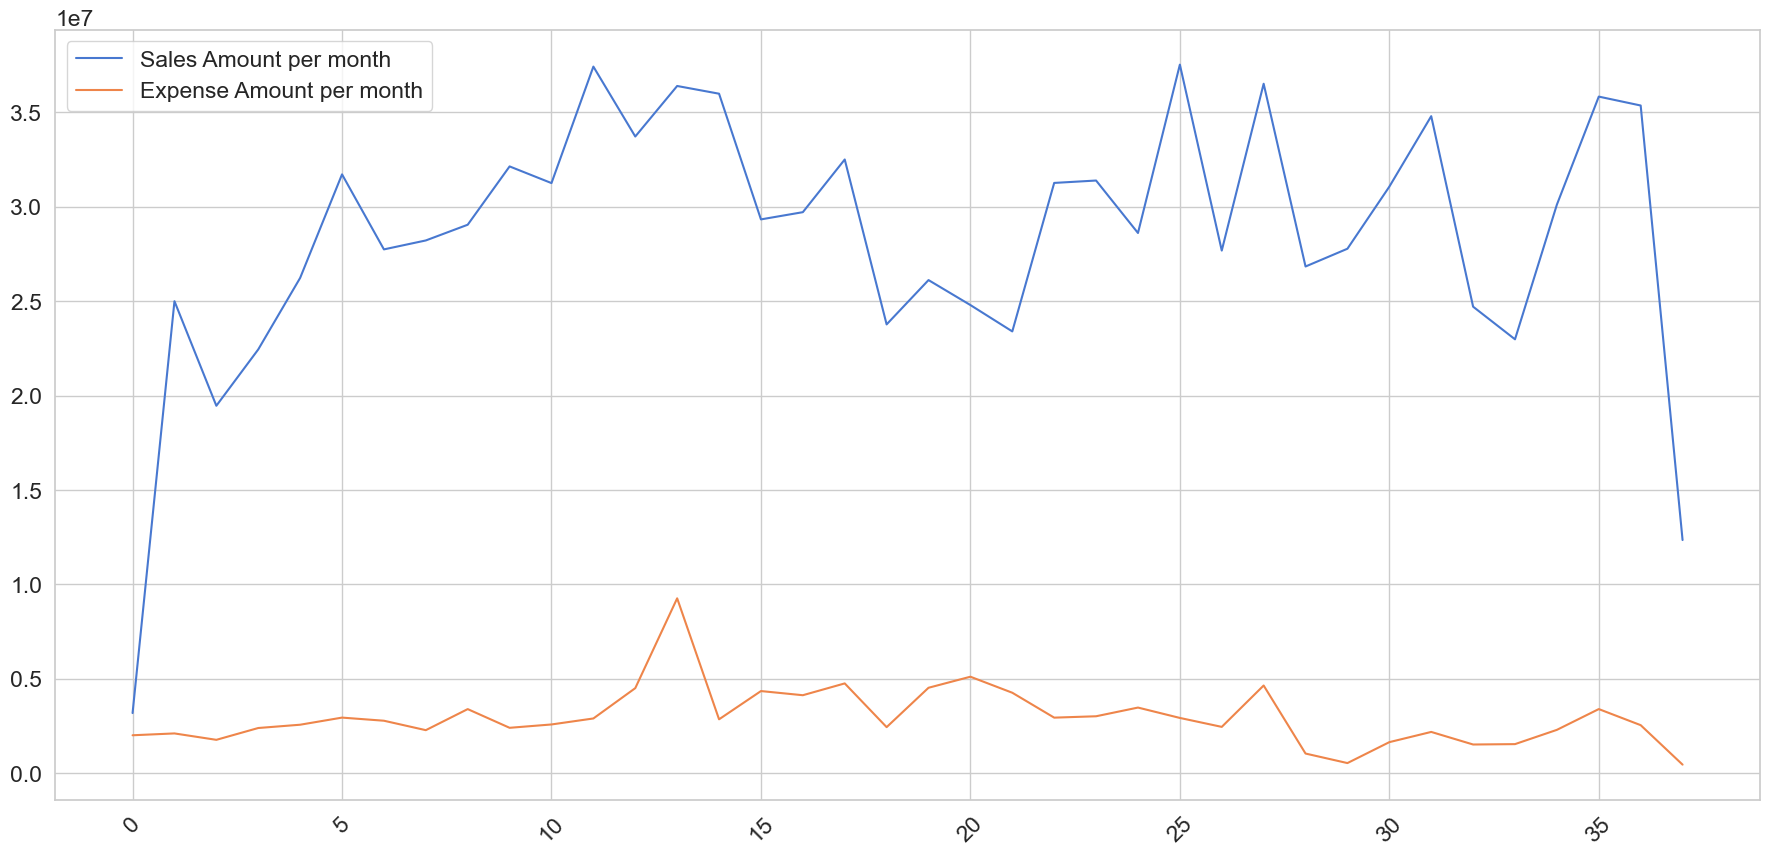

In [38]:
plt.plot(actual['Sales'], label='Sales Amount per month')
plt.plot(actual['Expenses'], label='Expense Amount per month')
plt.legend();
plt.xticks(rotation=45)

In [39]:
columns_to_scale = ['Sales', 'Expenses']

for columns in columns_to_scale:
    hmm[columns] = scaler.fit_transform(np.array(hmm[columns]).reshape(-1, 1))
    
scaled_data = hmm
scaled_data.head()

,Expenses,Sales
0,0.176589,0.000000
1,0.187632,0.635159
2,0.149110,0.473922
3,0.220218,0.560784
4,0.239970,0.671071


In [40]:
# The time series generator takes a sequence of numbers for x and y
# In this case we're sampling the same data, so X and Y have the same data
look_back=4
##################################################

# X = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)
##################################################

def df_to_X_y(df, look_back):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - look_back):
        row = [[a] for a in df_as_np[i:i+look_back]]
        X.append(row)
        label = df_as_np[i+look_back]
        y.append(label)
    return np.array(X), np.array(y)

In [41]:
EMX, EMy = df_to_X_y(scaled_data['Expenses'], look_back)
SMX, SMy = df_to_X_y(scaled_data['Sales'], look_back)
SMy.shape, EMy.shape

((34,), (34,))

In [42]:
SMy = np.expand_dims(SMy, axis=1)
EMy = np.expand_dims(EMy, axis=1)

In [43]:
X = np.concatenate((SMX, EMX), axis=1)
y = np.concatenate((SMy, EMy), axis=1)

In [44]:
# Split into training, testing and val.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, shuffle=True)
###################################################################################################################

In [45]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val)

(18, 18, 6, 6, 10, 10)

In [46]:
################################################################################################################################
from tensorflow.keras.losses import MeanSquaredError                                                                           #
from tensorflow.keras.metrics import RootMeanSquaredError                                                                      #
from tensorflow.keras.models import Sequential                                                                                 #
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten                                                                       #
from tensorflow.keras.callbacks import ModelCheckpoint                                                                         #
from tensorflow.keras.optimizers import Adam                                                                                   #
################################################################################################################################

In [47]:
monthly_model = Sequential([
    LSTM(550, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(128, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(2)
])
#Tried relu on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=3
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=3
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=4  ***
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.1 on second layer, dense=32, lookback=4 ***

# monthly_model = Sequential([
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation = 'relu'),
#     Dense(2)
# ])

# monthly_model = Sequential([
#     LSTM(128, return_sequences=True, activation='tanh'),
#     LSTM(128, return_sequences=True, activation='sigmoid'),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(2)
# ])


In [48]:
monthly_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics = [RootMeanSquaredError()])

In [60]:
monthly_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=2 , verbose=2)

Epoch 1/100
9/9 - 4s - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2198 - 4s/epoch - 484ms/step
Epoch 2/100
9/9 - 3s - loss: 0.0256 - root_mean_squared_error: 0.1601 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2243 - 3s/epoch - 329ms/step
Epoch 3/100
9/9 - 4s - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2029 - 4s/epoch - 427ms/step
Epoch 4/100
9/9 - 4s - loss: 0.0233 - root_mean_squared_error: 0.1525 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116 - 4s/epoch - 414ms/step
Epoch 5/100
9/9 - 3s - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2219 - 3s/epoch - 368ms/step
Epoch 6/100
9/9 - 3s - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2060 - 3s/epoch - 385ms/step
Epoch 7/100
9/9 - 4s - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0437 - val

Epoch 55/100
9/9 - 4s - loss: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2083 - 4s/epoch - 415ms/step
Epoch 56/100
9/9 - 4s - loss: 0.0221 - root_mean_squared_error: 0.1485 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2063 - 4s/epoch - 392ms/step
Epoch 57/100
9/9 - 3s - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2224 - 3s/epoch - 331ms/step
Epoch 58/100
9/9 - 3s - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2096 - 3s/epoch - 315ms/step
Epoch 59/100
9/9 - 3s - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2041 - 3s/epoch - 373ms/step
Epoch 60/100
9/9 - 3s - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2234 - 3s/epoch - 337ms/step
Epoch 61/100
9/9 - 3s - loss: 0.0203 - root_mean_squared_error: 0.1426 - val_loss: 0.044

<Axes: >

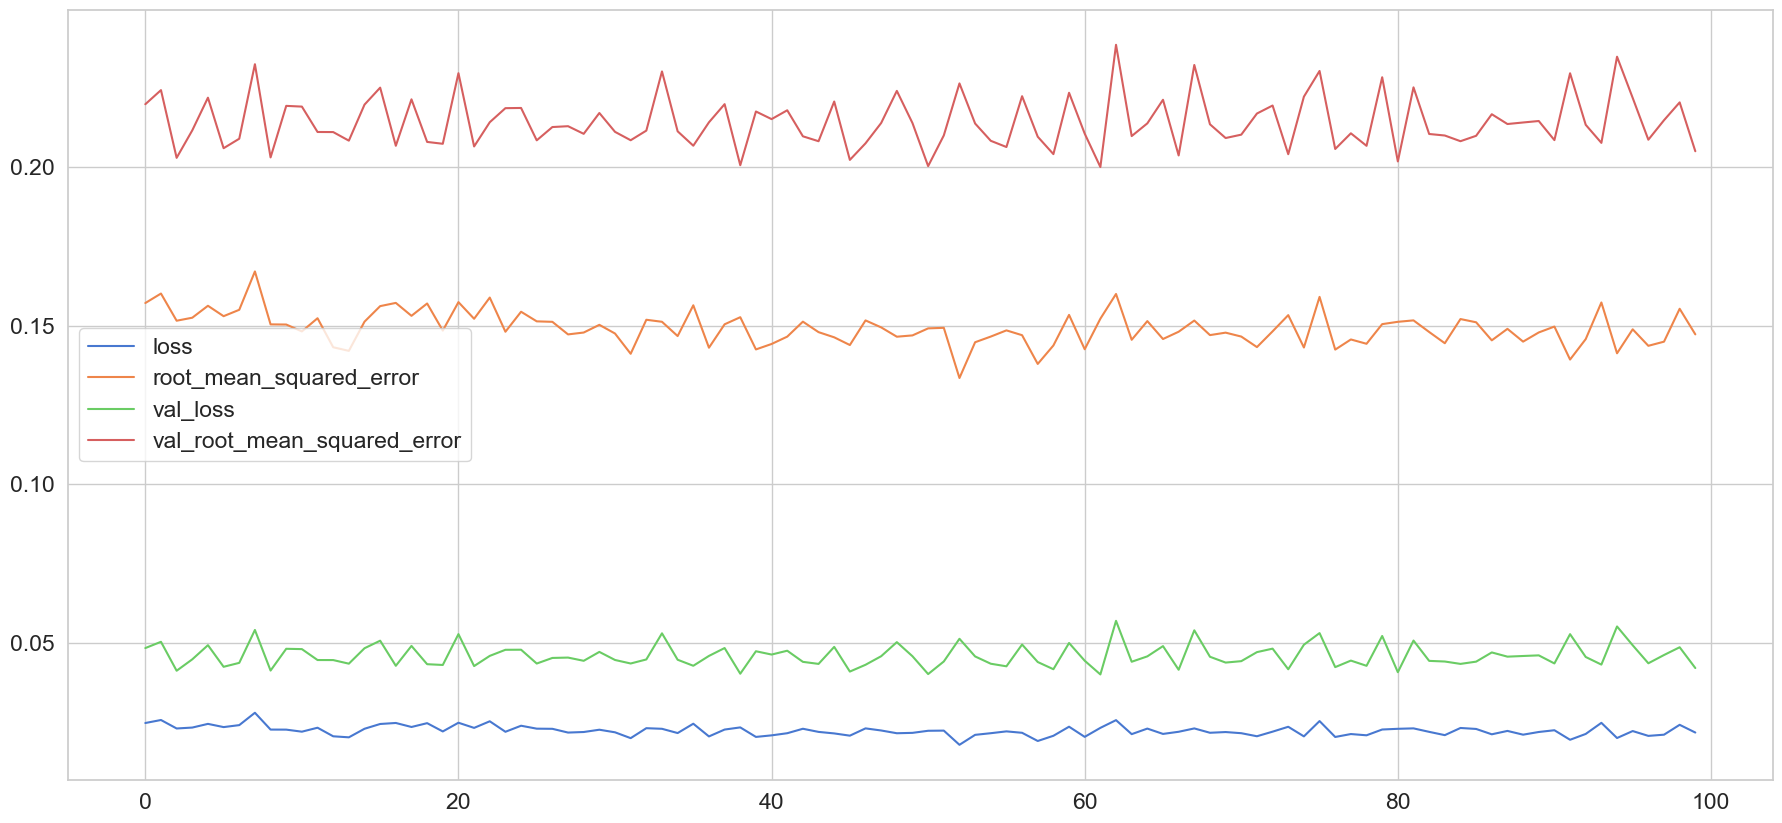

In [61]:
loss = pd.DataFrame(monthly_model.history.history)
loss.plot()

In [62]:
train_predict=monthly_model.predict(X)
train_predict=scaler.inverse_transform(train_predict)
train_predict.shape

2/2 [==============================] - 0s 44ms/step


(34, 2)

In [63]:
df = pd.DataFrame(train_predict, columns=['expenses', 'sales'])
df, len(df)

(     expenses       sales
 0   7352088.0  2507482.25
 1   7419410.5  2519423.00
 2   7410711.0  2619434.00
 3   7426986.5  2646277.75
 4   7414798.0  2620168.00
 5   7463846.0  2660920.00
 6   7424659.0  2667974.25
 7   7407382.0  2645785.00
 8   7393493.0  2687397.50
 9   7516852.0  2751801.50
 10  7867176.5  3297660.50
 11  7735966.0  3482354.00
 12  7624373.5  3459073.75
 13  7566430.0  3292930.75
 14  7660208.5  3077109.25
 15  7554765.0  3000845.25
 16  7602333.0  2971462.25
 17  7694508.0  3048911.50
 18  7713151.0  3092440.00
 19  7565175.5  3161819.75
 20  7463610.5  3003436.00
 21  7483334.5  2826395.50
 22  7471845.5  2796062.75
 23  7434131.5  2704796.25
 24  7518200.0  2828530.25
 25  7429656.0  2657912.75
 26  7263743.5  2465571.75
 27  7222856.5  2343958.25
 28  7261531.0  2267856.50
 29  7307256.5  2265294.25
 30  7334336.0  2298027.50
 31  7354366.5  2388039.50
 32  7386905.0  2538905.75
 33  7389925.0  2622657.50,
 34)

In [64]:
actual = pd.DataFrame(data={'Sales': sdf_monthly, 'Expenses':edf_monthly})
actual = pd.DataFrame(np.array(actual[look_back:]), columns=['sales', 'expenses'])
actual, len(actual)

(         sales   expenses
 0   26225713.0  2576390.0
 1   31706881.0  2953250.0
 2   27735977.0  2788040.0
 3   28209077.0  2288517.0
 4   29040989.0  3403150.0
 5   32128017.0  2413250.0
 6   31244921.0  2590300.0
 7   37411276.0  2907560.0
 8   33710895.0  4512300.0
 9   36385063.0  9266557.0
 10  35976421.0  2862578.0
 11  29323893.0  4357935.0
 12  29705951.0  4138127.0
 13  32494700.0  4763205.0
 14  23765663.0  2448500.0
 15  26111337.0  4532500.0
 16  24789659.0  5117140.0
 17  23393838.0  4269108.0
 18  31253918.0  2951285.0
 19  31380638.0  3023914.0
 20  28603720.0  3484350.0
 21  37515224.0  2935800.0
 22  27673354.0  2462150.0
 23  36503395.0  4652250.0
 24  26830619.0  1050750.0
 25  27771010.0   546350.0
 26  31056212.0  1654105.0
 27  34787425.0  2195350.0
 28  24703653.0  1529350.0
 29  22976497.0  1549450.0
 30  30105875.0  2304875.0
 31  35823008.0  3404500.0
 32  35351773.0  2553430.0
 33  12351805.0   464051.0,
 34)

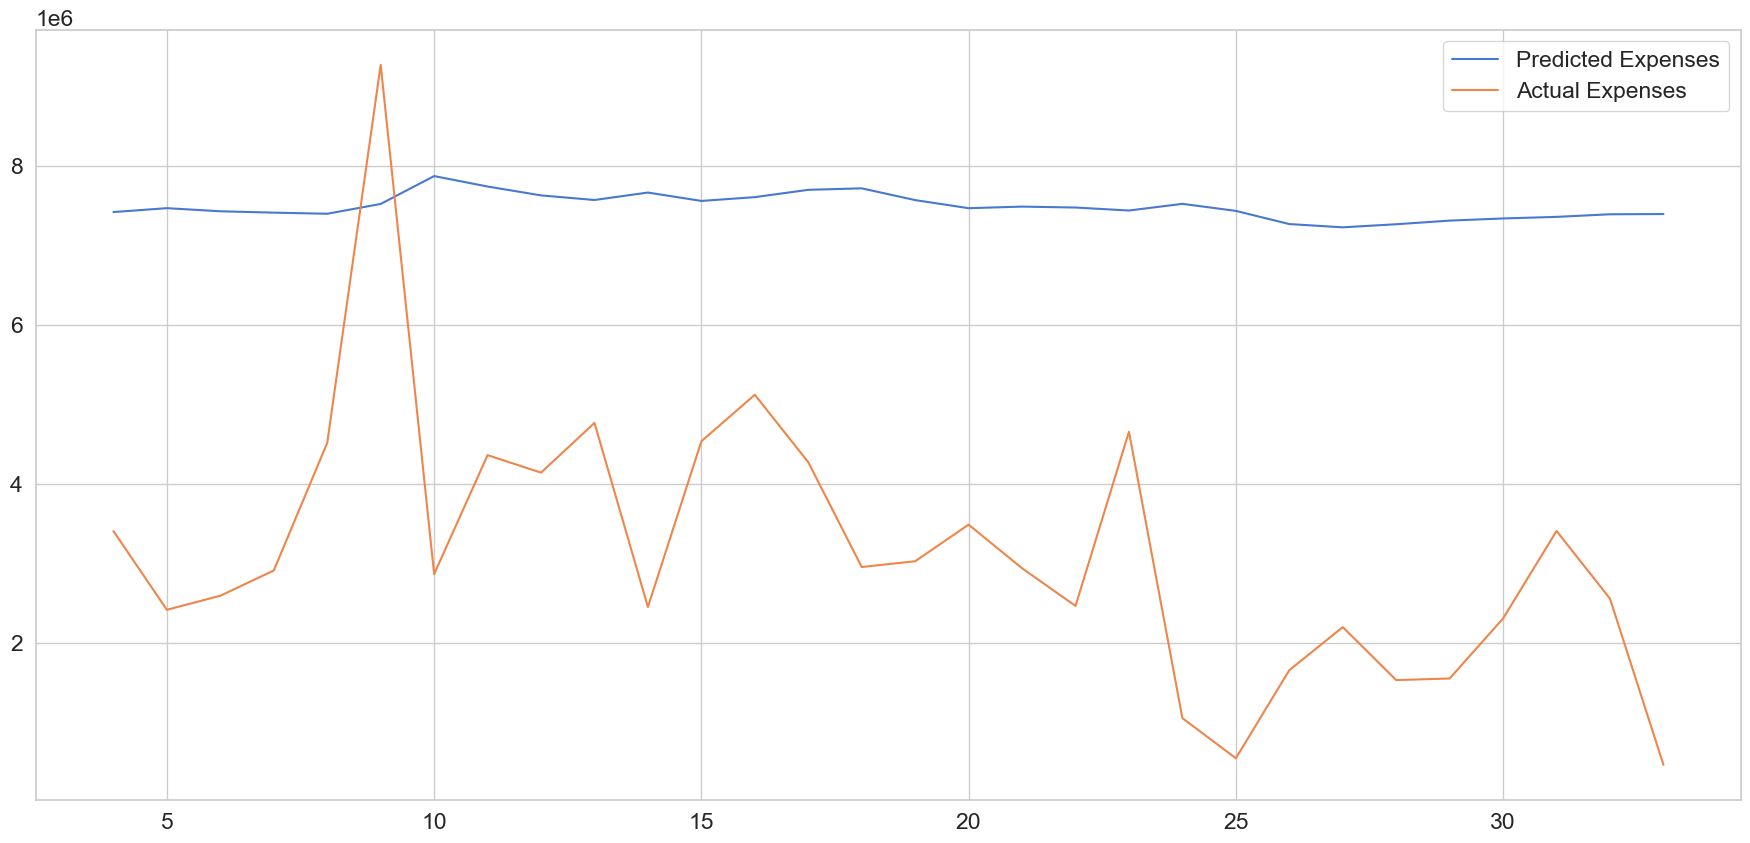

In [65]:
plt.plot(df.index[look_back:], df['expenses'][look_back:], label='Predicted Expenses')
plt.plot(df.index[look_back:], actual['expenses'][look_back:], label='Actual Expenses')
plt.legend()
plt.show()

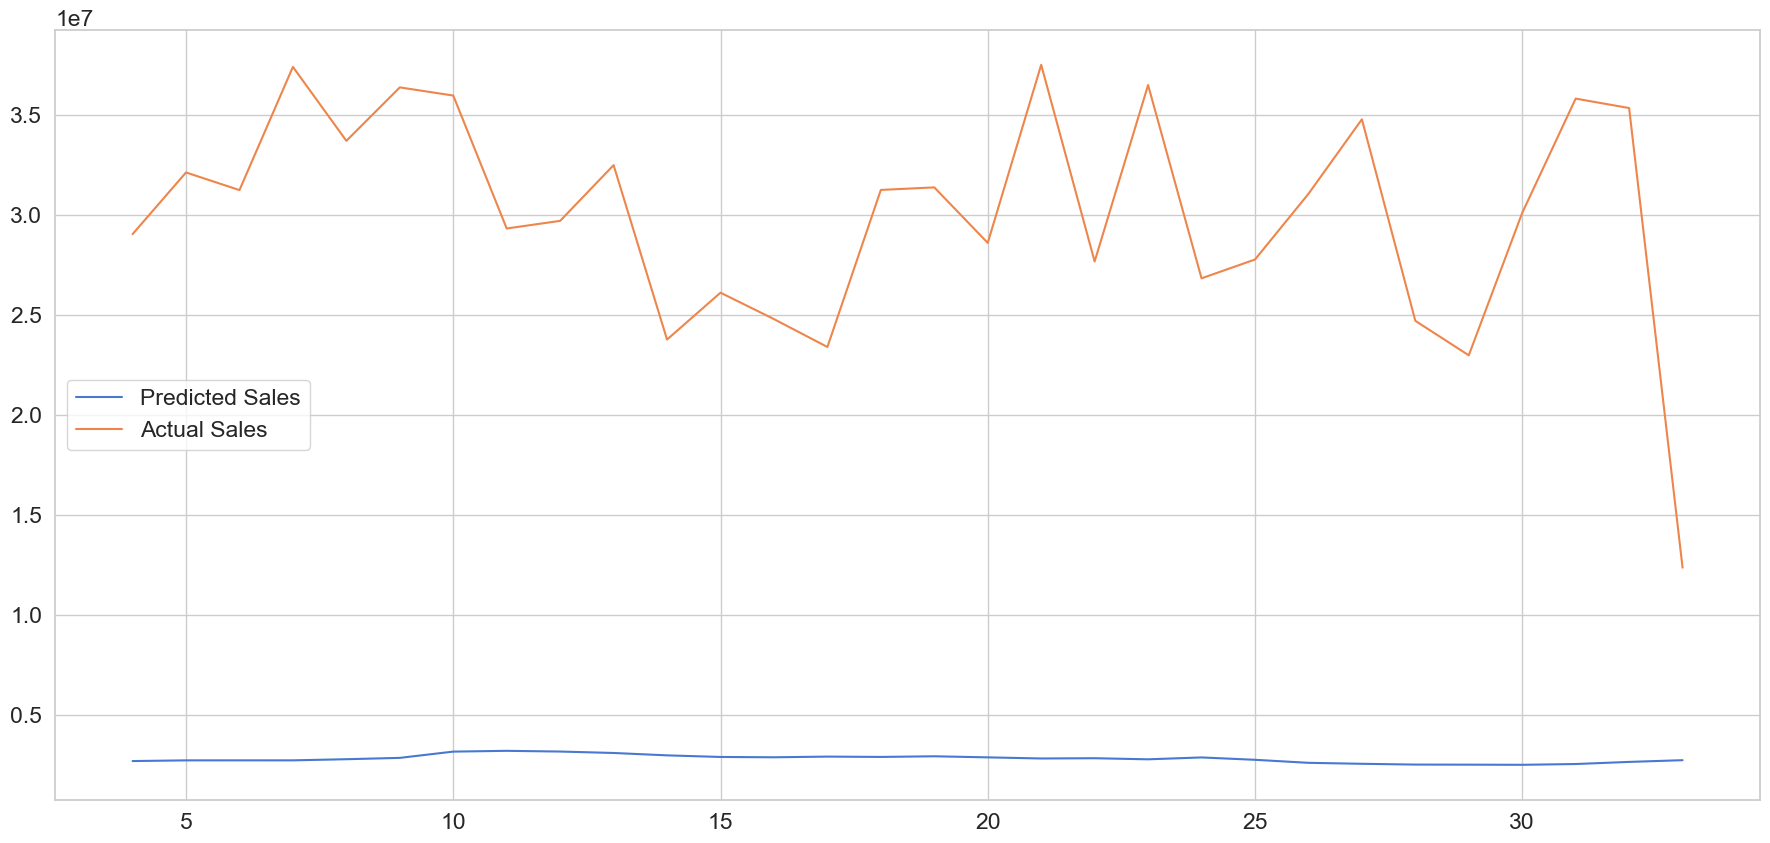

In [59]:
plt.plot(df.index[look_back:], df['sales'][look_back:], label='Predicted Sales')
plt.plot(df.index[look_back:], actual['sales'][look_back:], label='Actual Sales')
plt.legend()
plt.show()